In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from scipy import stats
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [2]:
filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2/2019*' 
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

ds size in GB 6.13



In [3]:
da_VVEL = ds.VVEL_500mb.load()
da_TMP = ds.TMP_500mb.load()

# mixing_ratio = ds.CLWMR_500mb.load()
mixing_ratio = ds.SPFH_500mb.load()

da_MSL = ds.PRES_meansealevel.load()
da_MSL = da_MSL/100 # convert to hPa

da_GPH = ds.HGT_250mb.load()

da_u = ds.UGRD_500mb.load() * 1.94384 ## convert to knots
da_v = ds.VGRD_500mb.load() * 1.94384 ## convert to knots
da_CAPE = ds.CAPE_surface.load()

In [4]:
## Convert VVel Omega (Pa/s) with respect to pressure to Vvel with respect for height (m/s)
omega = da_VVEL
pressure = 500.0 * units.hPa
temperature = da_TMP
mixing = mixing_ratio

In [5]:
VVEL = mpcalc.vertical_velocity(omega, pressure, temperature, mixing)
calc_VVEL = np.sqrt(da_CAPE*2.0)
calc_VVEL.max()

<xarray.DataArray 'CAPE_surface' ()>
array(102.946587)

In [6]:
## Put VVEL into ds for queries
vvel_ds = xr.Dataset({'vvel': (['time', 'lat', 'lon'], VVEL)},
                coords={'time': ds.time.values,
                        'lat': (['lat'], ds.latitude.values),
                        'lon': (['lon'], ds.longitude.values)})
vvel_ds

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 720, time: 9)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-04T18:00:00 ... 2019-03-06T18:00:00
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Data variables:
    vvel     (time, lat, lon) float32 -0.0069407243 ... -0.009132806

In [7]:
## Santa Barbara VVEL Info
SB_vvel = vvel_ds.vvel.sel(lat=[34.5], lon=[360-119.5], method='nearest')
# Max vvel and time
SB_max = SB_vvel.where(SB_vvel==SB_vvel.max(), drop=True).squeeze()
print('Max VVEL:', SB_max.values, 'm/s at', SB_max.time.values)


Max VVEL: 0.34641173 m/s at 2019-03-06T12:00:00.000000000


In [8]:
area_max = vvel_ds.vvel.where(vvel_ds.vvel==vvel_ds.vvel.max(), drop=True).squeeze()
area_max

<xarray.DataArray 'vvel' ()>
array(2.342851, dtype=float32)
Coordinates:
    time     datetime64[ns] 2019-03-05T18:00:00
    lat      float64 -22.5
    lon      float64 71.5

## Plot

./figures/figS2.png


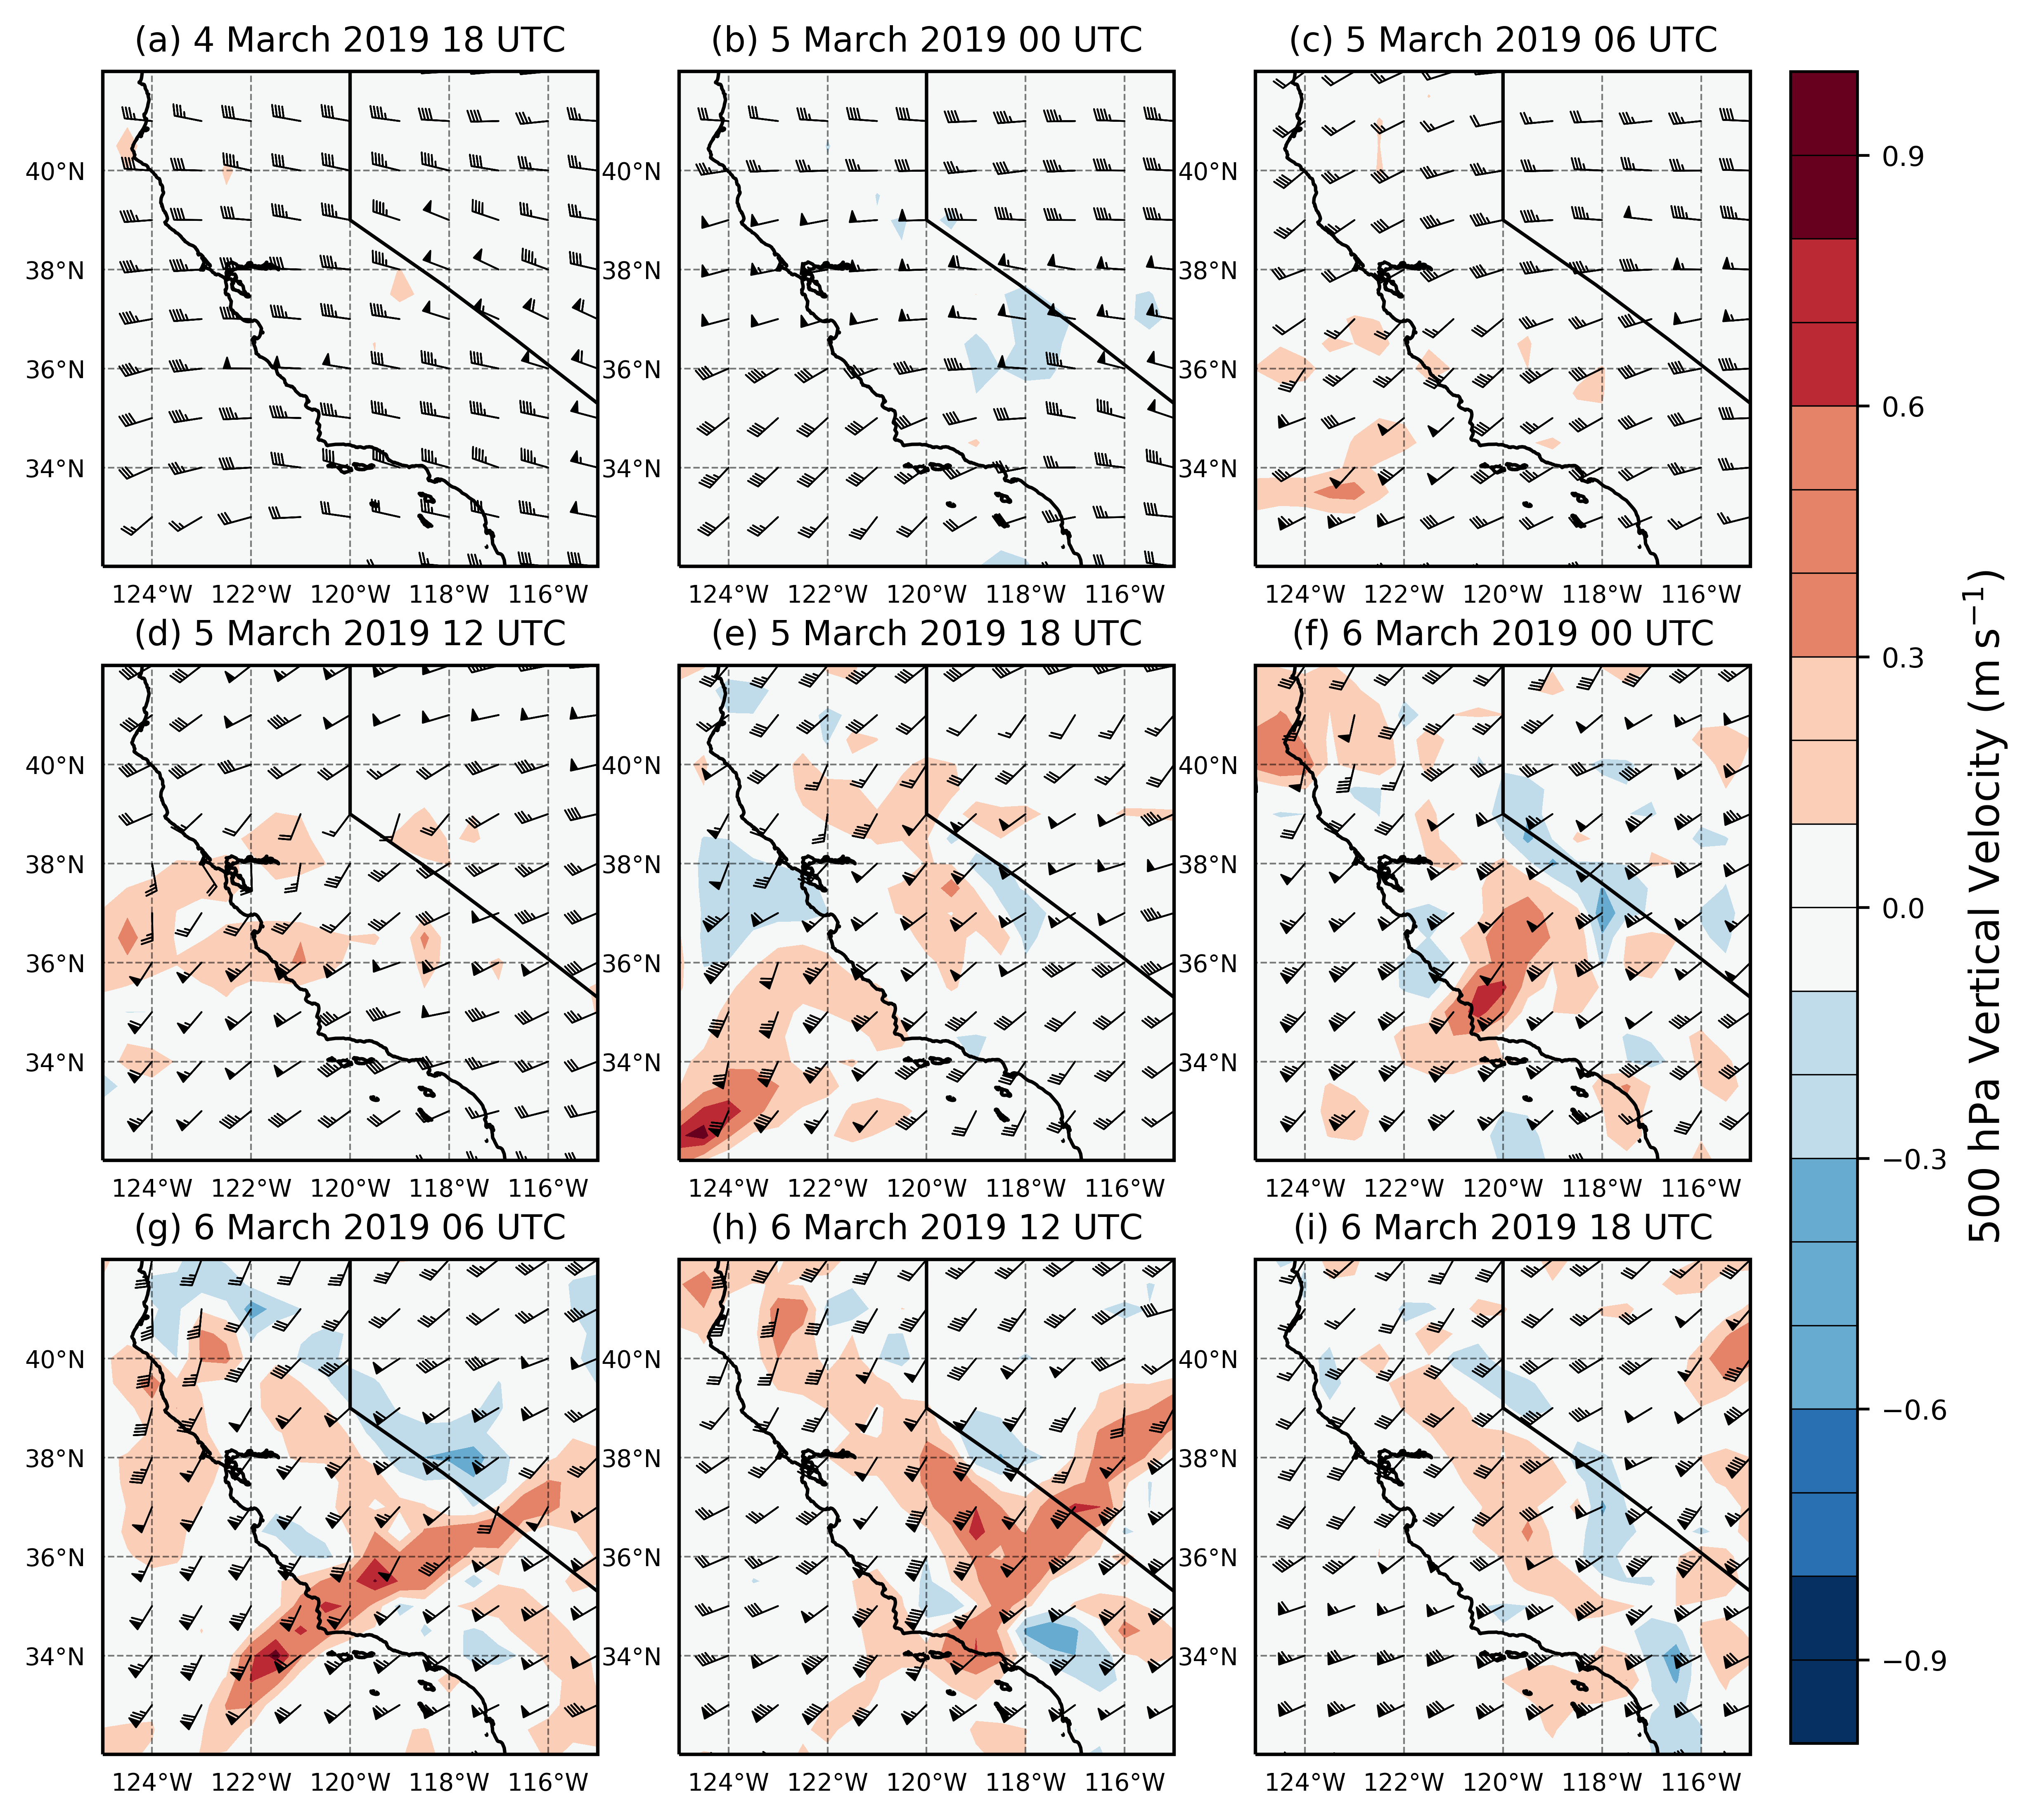

<Figure size 5400x5400 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/figS2'
fmt1 = 'png'
fmt2 = 'pdf'
results = VVEL
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

lats = ds['latitude']
lons = ds['longitude']

ext = [-115.0, -125.0, 32.0, 42.0]
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

bounds = np.linspace(-1, 1, 10)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
clevs = np.arange(-1.0, 1.1, 0.1)
for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=mapcrs)
    ax.set_extent(ext, crs=mapcrs)
    cf = ax.contourf(lons, lats, results[i], transform=datacrs,
                      norm=norm, cmap='RdBu_r', levels=clevs)
    barbx = 2
    barbs = ax.barbs(lons[::barbx], lats[::barbx],
                     da_u[i, ::barbx, ::barbx], da_v[i, ::barbx, ::barbx],
                     length=4, linewidth=0.5)
    
#     # Plot GPH
#     clevsgph = np.arange(0, 11000, 60)
#     kw_clabels = {'fontsize': 6, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
#                   'rightside_up': True, 'use_clabeltext': True}
#     cs = ax.contour(lons, lats, da_GPH[i,:,:], levels=clevsgph, colors='grey',
#                     linewidths=0.75, linestyles='solid', transform=datacrs)
#     plt.clabel(cs, **kw_clabels)
    
    
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
    gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto', extend='neither')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('500 hPa Vertical Velocity ($\mathrm{m \: s^{-1}}$)', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
# fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))